In [1]:
from imutils import face_utils
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

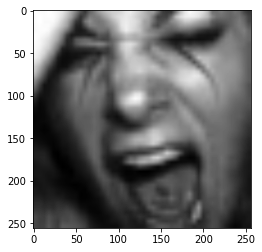

In [13]:
img = cv2.imread("../dataset-FER2013/detecting/detectable-face/testing/fear/fear_testing1016.jpg.jpg", 0)
image = cv2.resize(img, (256,256))

plt.imshow(image, cmap="gray")

In [2]:
def detecting(img):
    p = "./content/shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(p)
    
    rects = detector(img, 1)
    
    shape = None
    
    for (i, rect) in enumerate(rects):
        if rect is None:
            continue
        shape = predictor(img, rect)
        shape = face_utils.shape_to_np(shape)
        
    return shape

In [3]:
def eye_position(shape):
    left_eye_x = int(sum(shape[42:48, 0]))
    left_eye_y = int(sum(shape[42:48, 1]))
    
    right_eye_x = int(sum(shape[36:42, 0]))
    right_eye_y = int(sum(shape[36:42, 1]))
    
    return left_eye_x, left_eye_y, right_eye_x, right_eye_y

In [4]:
def face_alignment(img):
        
    shape = detecting(img)
    eyes = eye_position(shape)
    
    left_eye_x = eyes[0]
    left_eye_y = eyes[1]
    right_eye_x = eyes[2]
    right_eye_y = eyes[3]
    
    tan_angle = np.arctan((right_eye_y - left_eye_y)/(right_eye_x - left_eye_x))
    angle = np.degrees(tan_angle)
    
    rows, cols = img.shape    
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1, )
    aligned_img = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

    return aligned_img

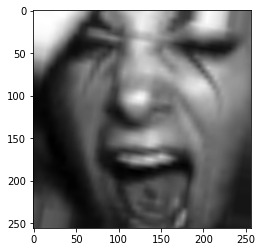

In [14]:
align = face_alignment(image)
plt.imshow(align, cmap='gray')

In [5]:
def image_cropping(img):
    landmarks = detecting(img)
    
    point = min([y for count, (x, y) in enumerate(landmarks) if count in range(17, 27) and y >=0])
    
    x1 = landmarks[0][0]
    x2 = landmarks[16][0]
    y2 = landmarks[8][1]
    
    if x1<0:
        x1 = 0
    elif x2 > 256:
        x2 = 256
    elif y2>256:
        y2 = 256

    cropped_image = img[point:y2, x1:x2]
    
    return cropped_image

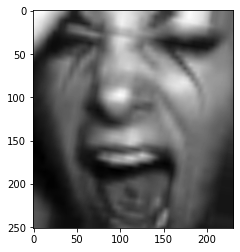

In [15]:
cropp = image_cropping(align)
plt.imshow(cropp, cmap='gray')

In [6]:
def Histogram_Equalization(img):
    HistEq = cv2.equalizeHist(img)
    
    HistEq = np.clip((HistEq - np.min(HistEq)) / (np.max(HistEq) - np.min(HistEq)) * 255, 0, 255)
    
    return HistEq

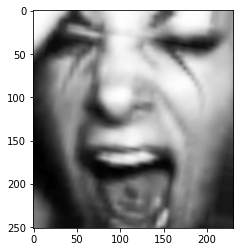

In [16]:
he = Histogram_Equalization(cropp)
plt.imshow(he, cmap='gray')

In [7]:
import cv2
import numpy as np
import os

def calc_mean_std(dataset_path):
    images = []

    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        for filename in os.listdir(label_path):
            image = cv2.imread(os.path.join(label_path, filename), 0)
            images.append(image)

    images = np.array(images)

    mean_value = np.mean(images)
    std_value = np.std(images)
    
    return mean_value, std_value

In [9]:
mean_train, std_train = calc_mean_std('../dataset-FER2013/detecting/detectable-face/training/')
mean_test, std_test = calc_mean_std('../dataset-FER2013/detecting/detectable-face/testing/')

In [11]:
def zscore_norm(mean, std, img):
    z_img = (img - mean) / std
    z_img = np.clip(z_img, 0, 255)
    
    return z_img


(<matplotlib.image.AxesImage at 0x17e042e5720>,
 Text(0.5, 1.0, 'paramater = img cropp, mean&std =HistEq'))

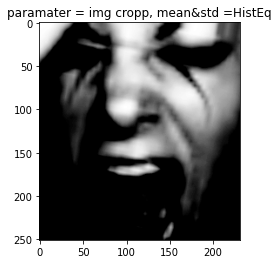

In [17]:
zs = zscore_norm(mean_train, std_train, he)
plt.imshow(zs, cmap='gray'), plt.title('paramater = img cropp, mean&std =HistEq')

In [12]:
def edge_detection(img):
    kirsch_kernels = [np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]),
                    np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]),
                    np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]),
                    np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]),
                    np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]),
                    np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]),
                    np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]),
                    np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]])
                    ]

    kirsch_grad = np.zeros_like(img)

    for kernel in kirsch_kernels:
        filtered = cv2.filter2D(img, -1, kernel)
        kirsch_grad = np.maximum(kirsch_grad, filtered)

    return kirsch_grad

(<matplotlib.image.AxesImage at 0x17e0440ac50>,
 Text(0.5, 1.0, 'histogram equalized'))

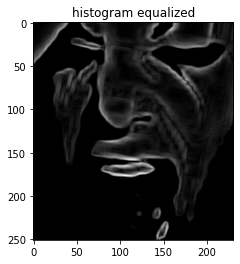

In [19]:
edge = edge_detection(zs)
plt.imshow(edge, cmap='gray'), plt.title('histogram equalized')

In [20]:
resize = cv2.resize(edge, (64,64))

In [ ]:
def save_preprocess(data, loc, mean, std):                
    img_list = [os.path.join(data, img) for img in os.listdir(data)]

    for img_path in img_list:
        name = os.path.basename(img_path)
        
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (256, 256))
        
        align = face_alignment(img)
        cropp = image_cropping(align)
        he = Histogram_Equalization(cropp)
        zscore = zscore_norm(mean, std, he)
        # grayEq = gray_equalized(cropp)
        edge = edge_detection(zscore)
        resize = cv2.resize(edge, (64, 64))
        
        output = (resize - np.min(resize)) / (np.max(resize) - np.min(resize)) * 255
        output = output.astype(np.uint8)

        cv2.imwrite(os.path.join(r'../dataset-FER2013/preprocessing-result2/', loc, name), output)

In [ ]:
save_preprocess('../dataset-FER2013/detecting/detectable-face/training/angry/', 'training/angry/', mean_train, std_train)
save_preprocess('../dataset-FER2013/detecting/detectable-face/training/disgust/', 'training/disgust/', mean_train, std_train)
save_preprocess('../dataset-FER2013/detecting/detectable-face/training/fear/', 'training/fear/', mean_train, std_train)
save_preprocess('../dataset-FER2013/detecting/detectable-face/training/happy/', 'training/happy/', mean_train, std_train)
save_preprocess('../dataset-FER2013/detecting/detectable-face/training/neutral/', 'training/neutral/', mean_train, std_train)
save_preprocess('../dataset-FER2013/detecting/detectable-face/training/sad/', 'training/sad/', mean_train, std_train)
save_preprocess('../dataset-FER2013/detecting/detectable-face/training/surprise/', 'training/surprise/', mean_train, std_train)

save_preprocess('../dataset-FER2013/detecting/detectable-face/testing/angry/', 'testing/angry/', mean_test, std_test)
save_preprocess('../dataset-FER2013/detecting/detectable-face/testing/disgust/', 'testing/disgust/', mean_test, std_test)
save_preprocess('../dataset-FER2013/detecting/detectable-face/testing/fear/', 'testing/fear/', mean_test, std_test)
save_preprocess('../dataset-FER2013/detecting/detectable-face/testing/happy/', 'testing/happy/', mean_test, std_test)
save_preprocess('../dataset-FER2013/detecting/detectable-face/testing/neutral/', 'testing/neutral/', mean_test, std_test)
save_preprocess('../dataset-FER2013/detecting/detectable-face/testing/sad/', 'testing/sad/', mean_test, std_test)
save_preprocess('../dataset-FER2013/detecting/detectable-face/testing/surprise/', 'testing/surprise/', mean_test, std_test)